In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
import matplotlib.pyplot as plt

In [2]:
csv_files = ['INFY.csv', 'TATAMOTORS.csv', 'ADANIPORTS.csv', 'ADANIPOWERS.csv']
path = '/content/drive/MyDrive/Colab Notebooks/STOCK'

In [4]:
merged_data = None
for file in csv_files:
    df = pd.read_csv(os.path.join(path, file))
    df['Date'] = pd.to_datetime(df['Date'], format='%d-%B-%Y')
    df = df[['Date', 'Close Price']].sort_values(by='Date')
    df.rename(columns={'Close Price': file.split('.')[0]}, inplace=True)
    merged_data = df if merged_data is None else pd.merge(merged_data, df, on='Date')

In [5]:
merged_data

,Date,INFY,TATAMOTORS,ADANIPORTS,ADANIPOWERS
0,2010-01-04,2614.25,827.40,556.25,99.10
1,2010-01-05,2620.00,810.95,576.90,105.10
2,2010-01-06,2584.60,812.10,604.40,107.50
3,2010-01-07,2525.25,784.75,596.45,105.05
4,2010-01-08,2464.45,789.15,594.70,103.70
...,...,...,...,...,...
3468,2023-12-26,1544.50,719.65,1027.95,512.15
3469,2023-12-27,1566.50,740.60,1024.30,521.55
3470,2023-12-28,1563.00,754.20,1017.05,521.25
3471,2023-12-29,1542.85,780.75,1024.15,524.85


In [6]:
# Preprocess data
merged_data = merged_data.drop(columns=['Date'])
scaler = MinMaxScaler()
price_data_scaled = scaler.fit_transform(merged_data)

In [7]:
X, y = price_data_scaled[:-1], price_data_scaled[1:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [8]:
# Define the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.1),
    LSTM(50),
    Dense(merged_data.shape[1])  # Output layer for multiple companies
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=80, validation_data=(X_test, y_test), verbose=1)

Epoch 1/80
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0617 - val_loss: 0.0234
Epoch 2/80
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0184 - val_loss: 0.0079
Epoch 3/80
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0076 - val_loss: 0.0066
Epoch 4/80
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0064 - val_loss: 0.0057
Epoch 5/80
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0059 - val_loss: 0.0052
Epoch 6/80
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 7/80
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0045 - val_loss: 0.0039
Epoch 8/80
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0040 - val_loss: 0.0036
Epoch 9/80
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0035 - val_loss: 0.0028
Epoch 10/80
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0029 - val_loss: 0.0023
Epoch 11/80
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 12/80
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0019 - val_lo

In [10]:
# Make predictions
predictions = model.predict(X_test)
predictions_inverse = scaler.inverse_transform(predictions)
actual_inverse = scaler.inverse_transform(y_test)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


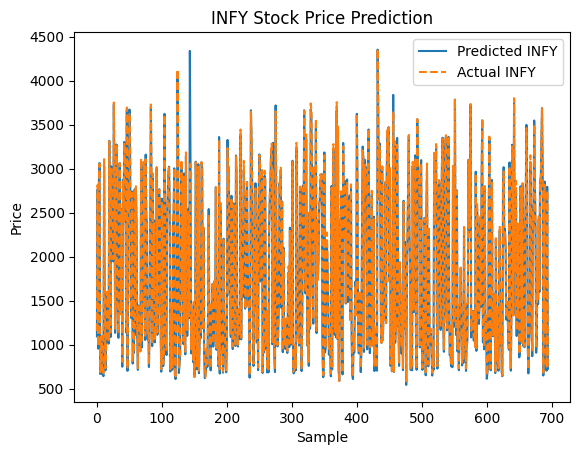

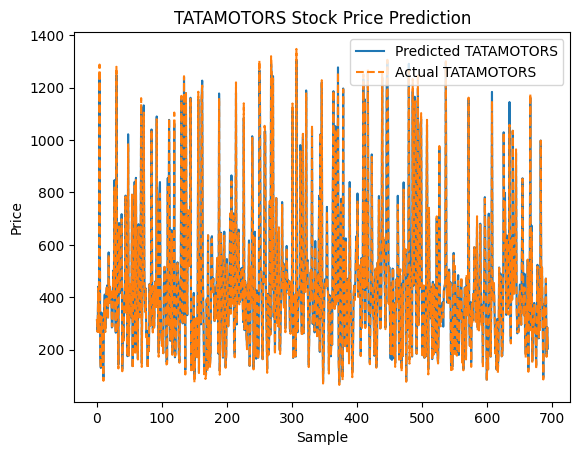

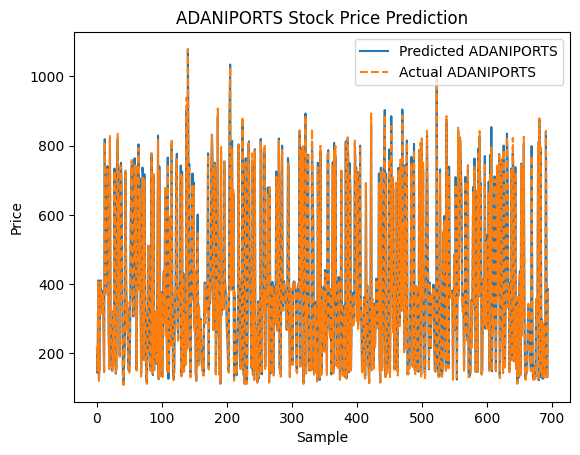

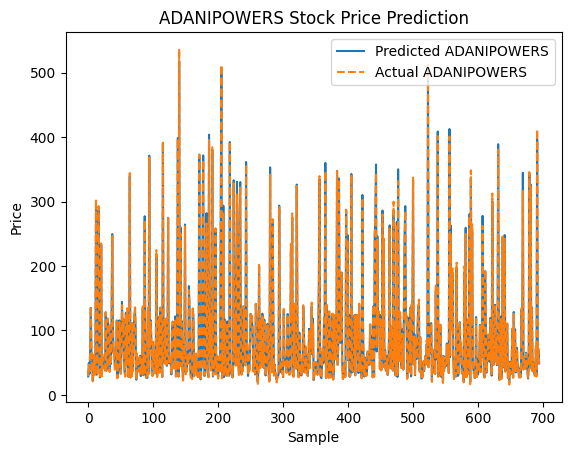

In [20]:
# Plot actual and predicted prices for each company
for i, company in enumerate(merged_data.columns):
    plt.plot(predictions_inverse[:, i], label=f'Predicted {company}')
    plt.plot(actual_inverse[:, i], label=f'Actual {company}', linestyle='dashed')
    plt.title(f'{company} Stock Price Prediction')
    plt.xlabel('Sample')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

In [21]:
def show_company_stock(company_name):
    if company_name not in merged_data.columns:
        print(f"Company '{company_name}' not found. Available options: {list(merged_data.columns)}")
        return

    company_index = merged_data.columns.get_loc(company_name)
    print(f"Predicted prices for {company_name}: {predictions_inverse[:5, company_index]}")
    print(f"Actual prices for {company_name}: {actual_inverse[:5, company_index]}")

# Input from user

# Suggest available companies for the user to choose from
company_names = merged_data.columns.tolist()
print(f"Available companies: {', '.join(company_names)}")

company_name = input("Enter the company name: ")
show_company_stock(company_name)

Available companies: INFY, TATAMOTORS, ADANIPORTS, ADANIPOWERS
Enter the company name: TATAMOTORS
Predicted prices for TATAMOTORS: [ 311.64093  268.9939   440.41013  277.94165 1231.949  ]
Actual prices for TATAMOTORS: [ 317.    267.65  435.1   268.1  1288.15]


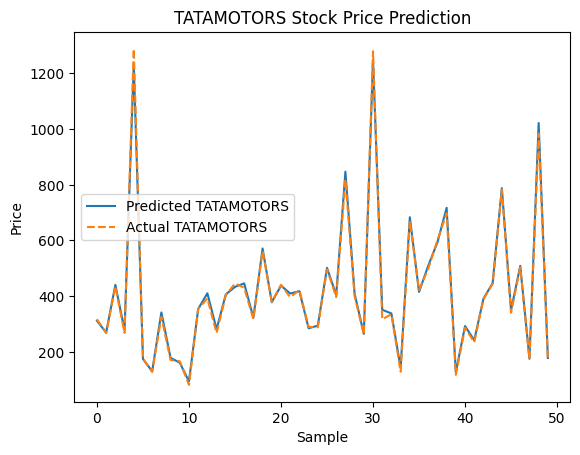

In [22]:
# Plot the stock prices for the chosen company
def plot_company_stock(company_name):
    company_index = merged_data.columns.get_loc(company_name)
    plt.plot(predictions_inverse[:50, company_index], label=f'Predicted {company_name}')
    plt.plot(actual_inverse[:50, company_index], label=f'Actual {company_name}', linestyle='dashed')
    plt.title(f'{company_name} Stock Price Prediction')
    plt.xlabel('Sample')
    plt.ylabel('Price')
    plt.legend()
    plt.show()
plot_company_stock(company_name)